# First GOP Debate Twitter Sentiment

This notebook is built with Natural Language Toolkit (NLTK) in Python 3.

I use the dataset from [Kaggle](https://www.kaggle.com/crowdflower/first-gop-debate-twitter-sentiment/data)  

This data originally came from [Crowdflower's Data for Everyone library](https://www.crowdflower.com/data-for-everyone/).  

As the original source says,  


We looked through tens of thousands of tweets about the early August GOP debate in Ohio and asked contributors to do both sentiment analysis and data categorization. Contributors were asked if the tweet was relevant, which candidate was mentioned, what subject was mentioned, and then what the sentiment was for a given tweet. We've removed the non-relevant messages from the uploaded dataset.

### Sentiment Analysis:  

the process of computationally identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral.

## Step 1 

Import the packages.

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # function for splitting data to train and test sets

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output

# Input data files are available in the root directory.

I decided to only do sentiment analysis on this dataset, so I dropped the unnecessary colunns, keeping only sentiment and text.

In [6]:
data = pd.read_csv('Sentiment.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

First of all, splitting the dataset into a training and a testing set.  
The testing set is the 10% of the original dataset.   
For this particular analysis, I dropped the neutral tweets, as my goal was to only differentiate positive and negative tweets.

In [7]:
# Split the dataset into train and test set
train, test = train_test_split(data,test_size = 0.1)
# Remove neutral sentiments
train = train[train.sentiment != "Neutral"]

As a next step I separated the Positive and Negative tweets of the training set in order to easily visualize their contained words.   
After that I cleaned the text from hashtags, mentions and links.  
Then they were ready for a WordCloud visualization which shows only the most emphatic words of the Positive and Negative tweets.

Positive words


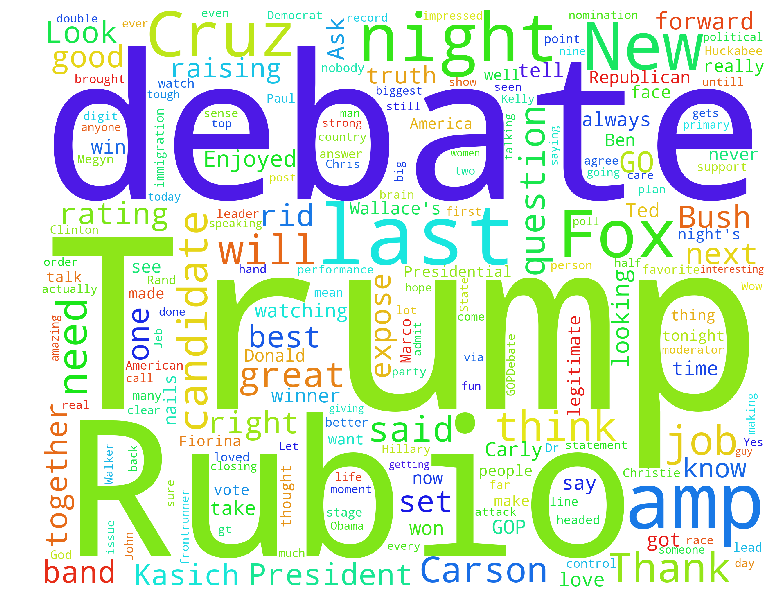

Negative words


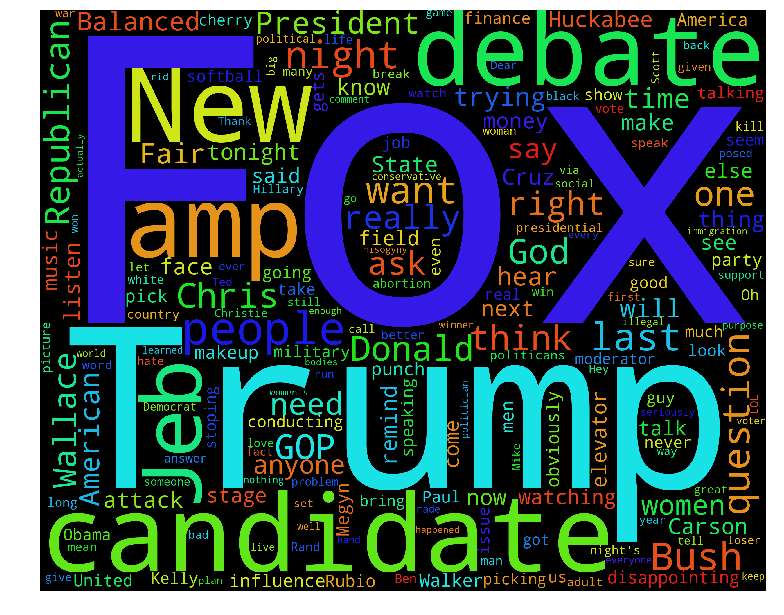

In [12]:
train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['text']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

Interesting to notice the following words and expressions in the positive word set: **truth**, **strong**, **legitimate**, **together**, **love**, **job**.  

In my interpretation, people tend to believe that their ideal candidate is truthful, legitimate, above good and bad.    
  
------------------------------------------------------------------------------------------------------------------------------  
At the same time, negative tweets contains words like: **influence**, **news**, **elevator music**, **disappointing**, **softball**, **makeup**, **cherry picking, trying**.  
  
In my understanding people missed the decisively acting and considered the scolded candidates too soft and cherry picking.  
  
After the vizualization, I removed the hashtags, mentions, links and stopwords from the training set.  
    
-----------------------------------------------------------------------------------------------------------------------------  

  
**Stop Word**: Stop Words are words which do not contain important significance to be used in Search Queries. Usually these words are filtered out from search queries because they return vast amount of unnecessary information. ( the, for, this, etc. )

***Note*** : Need to download **stopwords** by using the following command

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [8]:
tweets = []
stopwords_set = set(stopwords.words("english"))

for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_cleaned,row.sentiment))

test_pos = test[ test['sentiment'] == 'Positive']
test_pos = test_pos['text']
test_neg = test[ test['sentiment'] == 'Negative']
test_neg = test_neg['text']

As a next step I extracted the so called features with nltk lib, first by measuring a frequent distribution and by selecting the resulting keys.

In [10]:
# Extracting word features
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['containts(%s)' % word] = (word in document_words)
    return features

Hereby I plotted the most frequently distributed words.  
The most words are centered around debate nights.

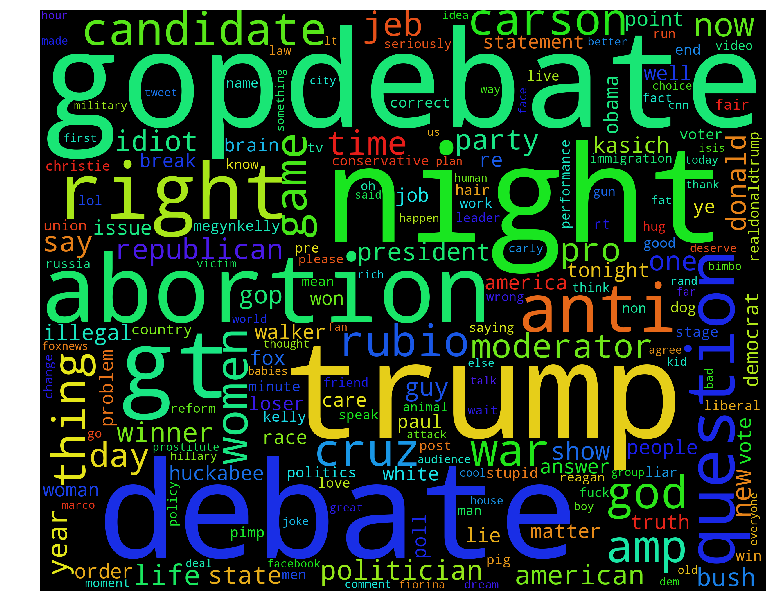

In [13]:
wordcloud_draw(w_features)

Using the nltk NaiveBayes Classifier, I classified the extracted tweet word features.

In [14]:
# Train the Naive Bayes classifier
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

Finally, with not-so-intelligent metrics, I tried to measure how the classifier algorithm scored.

In [15]:
neg_cnt = 0
pos_cnt = 0
for obj in test_neg: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Negative'): 
        neg_cnt = neg_cnt + 1
for obj in test_pos: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Positive'): 
        pos_cnt = pos_cnt + 1
        
print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))        
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt)) 

[Negative]: 836/789 
[Positive]: 237/84 


## Epilog 

In this project I was curious how well nltk and the NaiveBayes Machine Learning algorithm performs for Sentiment Analysis. In my experience, it works rather well for negative comments. The problems arise when the tweets are ironic, sarcastic has reference or own difficult context.  
  
  

Consider the following tweet: "Muhaha, how sad that the Liberals couldn't destroy Trump. Marching forward." As you may already thought, the words **sad** and **destroy** highly influences the evaluation, although this tweet should be positive when observing its meaning and context.  
  
  

To improve the evalutation accuracy, we need something to take the context and references into consideration. As [the project 2.0](https://github.com/louispoweichen/First_GOP_Debate_Twitter_Sentiment/blob/master/first_GOP_debate_twitter_sentiment.ipynb), I will try to build an LSTM network, and benchmark its results compared to this nltk Machine Learning implementation. Stay tuned.